Lets start simple: 1 hidden layer networks trained on moons dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.cluster.hierarchy import leaves_list, linkage

from architecture.MLP import FCNet, train
from permute import permute_align
from utils import (
    evaluate,
    interpolation_losses,
    loss_barrier,
)
from scipy.optimize import linear_sum_assignment

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# config
widths = [4, 8, 16, 32, 128, 512]
num_models = 50
depth = 1
epochs = 60

#load data from data/moons.npz
file = np.load("data/moons.npz")
X_train = file["X_train"]
y_train = file["y_train"]
X_test = file["X_test"]
y_test = file["y_test"]

# define train and test loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
    ),
    batch_size=256,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
    ),
    batch_size=256,
    shuffle=False,
)

In [ ]:
for width in widths:
    # data structure to store losses and accuracies
    logs = np.zeros((num_models, 4))

    # Define and train many models
    models = []
    for i in range(num_models):
        model = FCNet(input_size=2, width=width, depth=depth, output_size=1)
        train(
            model,
            train_loader,
            epochs=epochs,
            lr=0.001,
            model_name=f"moons/model_w{width}_{i}",
        )
        models.append(model)

        # evaluate
        model.eval()

        train_loss, train_acc = evaluate(model, train_loader)
        test_loss, test_acc = evaluate(model, test_loader)

        logs[i, 0] = train_loss
        logs[i, 1] = test_loss
        logs[i, 2] = train_acc
        logs[i, 3] = test_acc

        # save the logs
        np.save(f"logs/moons/logs_w{width}", logs)

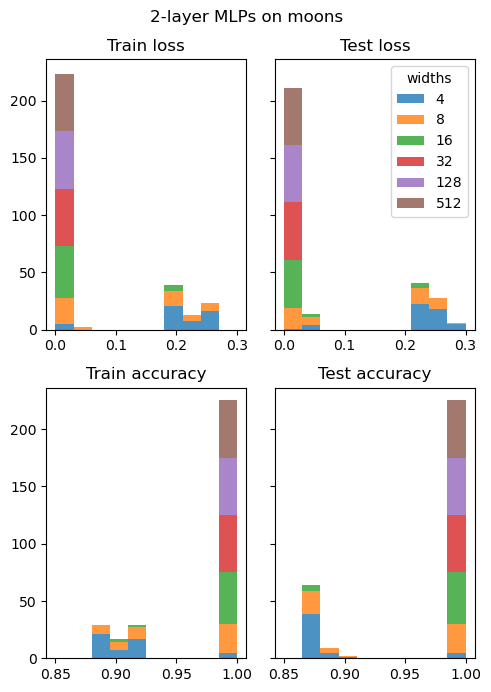

In [ ]:
# visualizing model losses and accuracies
fig, axes = plt.subplots(2, 2, figsize=(5, 7), sharey=True)
# title
fig.suptitle("2-layer MLPs on moons")

# for widths, load the model losses and accuracies and show their stacked histograms
train_losses = np.zeros((num_models, len(widths)))
test_losses = np.zeros((num_models, len(widths)))
train_accs = np.zeros((num_models, len(widths)))
test_accs = np.zeros((num_models, len(widths)))
                      
for i, width in enumerate(widths):
    model_logs = np.load(
        f"logs/moons/logs_w{width}.npy"
    )
    train_losses[:, i] = model_logs[:, 0]
    test_losses[:, i] = model_logs[:, 1]
    train_accs[:, i] = model_logs[:, 2]
    test_accs[:, i] = model_logs[:, 3]

# show train loss
axes[0, 0].hist(train_losses, bins=10, stacked=True, label=widths, range=(0, 0.3), alpha=0.8)
axes[0, 0].set_title("Train loss")

axes[0, 1].hist(test_losses, bins=10, stacked=True, label=widths, range=(0, 0.3), alpha=0.8)
axes[0, 1].set_title("Test loss")
axes[0, 1].legend(title="widths")
axes[1, 0].hist(train_accs, bins=10, stacked=True, label=widths, range=(0.85, 1), alpha=0.8)
axes[1, 0].set_title("Train accuracy")

axes[1, 1].hist(test_accs, bins=10, stacked=True, label=widths, range=(0.85, 1), alpha=0.8)
axes[1, 1].set_title("Test accuracy")


# padding
fig.tight_layout(pad=1.0)
# save
plt.savefig("model_performance.png", dpi=300)

Without loss of generality, let model 0 be the reference to align the other models to.

In [ ]:
# given ref model and model, return realigned model
def weight_matching(ref_model, model):
    width = ref_model.layers[0].weight.shape[0]
    # compute cost
    cost = torch.zeros((width, width)).to(device)
    cost += torch.matmul(ref_model.layers[0].weight, model.layers[0].weight.T)
    cost += torch.matmul(
        ref_model.layers[0].bias.unsqueeze(1), model.layers[0].bias.unsqueeze(0)
    )
    cost += torch.matmul(ref_model.layers[1].weight.T, model.layers[1].weight)

    # get permutation using hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy(), maximize=True)
    perm = torch.zeros(cost.shape).to(device)
    perm[row_ind, col_ind] = 1

    # realign model
    model.layers[0].weight = torch.nn.Parameter(
        torch.matmul(perm, model.layers[0].weight)
    )
    model.layers[0].bias = torch.nn.Parameter(
        torch.matmul(perm, model.layers[0].bias.unsqueeze(1)).squeeze()
    )
    model.layers[1].weight = torch.nn.Parameter(
        torch.matmul(model.layers[1].weight, perm.T)
    )

    return model

In [ ]:
for w in widths:
    ref_model = FCNet(2, w, 1, 1).to(device)
    ref_model.load_state_dict(torch.load(f"models/moons/model_w{w}_0.pth"))
    ref_model.eval()

    for i in range(1, num_models):
        model = FCNet(2, w, 1, 1).to(device)
        model.load_state_dict(torch.load(f"models/moons/model_w{w}_{i}.pth"))
        model.eval()

        model = weight_matching(ref_model, model)
        torch.save(model.state_dict(), f"models/moons/perm_model_w{w}_{i}.pth")

Let us see what naive interpolation between models look like

In [ ]:
for width in widths:
    for data in ["train", "test"]:
        # choose loader
        if data == "train":
            loader = train_loader
        else:
            loader = test_loader

        # data structure to store interpolation losses
        int_losses = np.zeros((num_models, num_models, 11))

        # data structure to store loss barriers
        barriers = np.zeros((num_models, num_models))

        # data structure to store max barrier
        max_barriers = np.zeros((num_models, num_models))

        # compute interpolation loss for each pair of models
        # log the results
        for i in range(num_models):
            for j in range(num_models):
                if i == j:
                    continue
                if i > j:
                    int_losses[i, j, :] = int_losses[j, i, :]
                    barriers[i, j] = barriers[j, i]
                    max_barriers[i, j] = max_barriers[j, i]
                    continue
                if i < j:
                    int_losses[i, j, :] = interpolation_losses(
                        models[i], models[j], loader
                    )
                    barriers[i, j] = loss_barrier(int_losses[i, j, :])
                    max_barriers[i, j] = max(int_losses[i, j, :])

        np.save(
            f"logs/moons/naive_int_losses_{data}_w{width}",
            int_losses,
        )
        np.save(
            f"logs/moons/naive_barriers_{data}_w{width}",
            barriers,
        )
        np.save(
            f"logs/moons/naive_max_barriers_{data}_w{width}",
            max_barriers,
        )

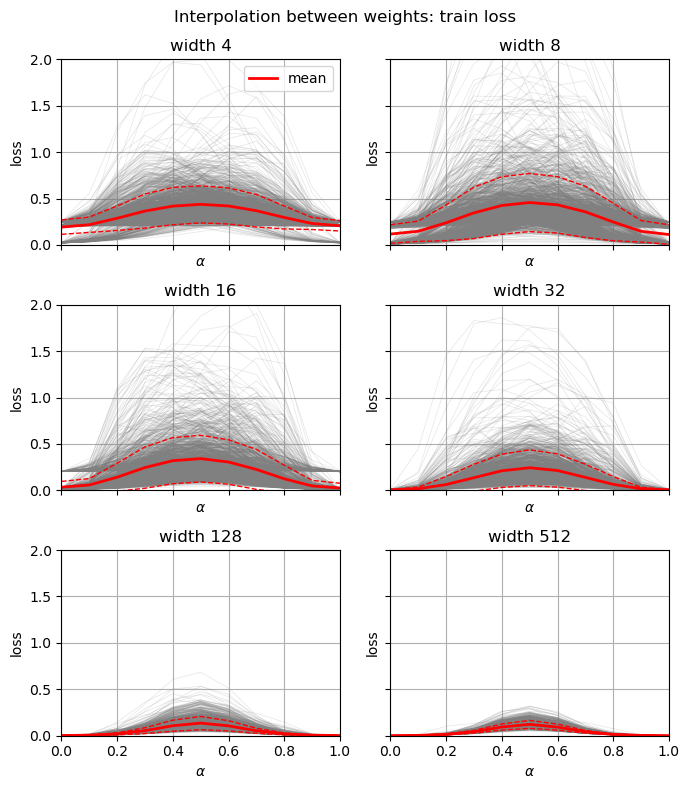

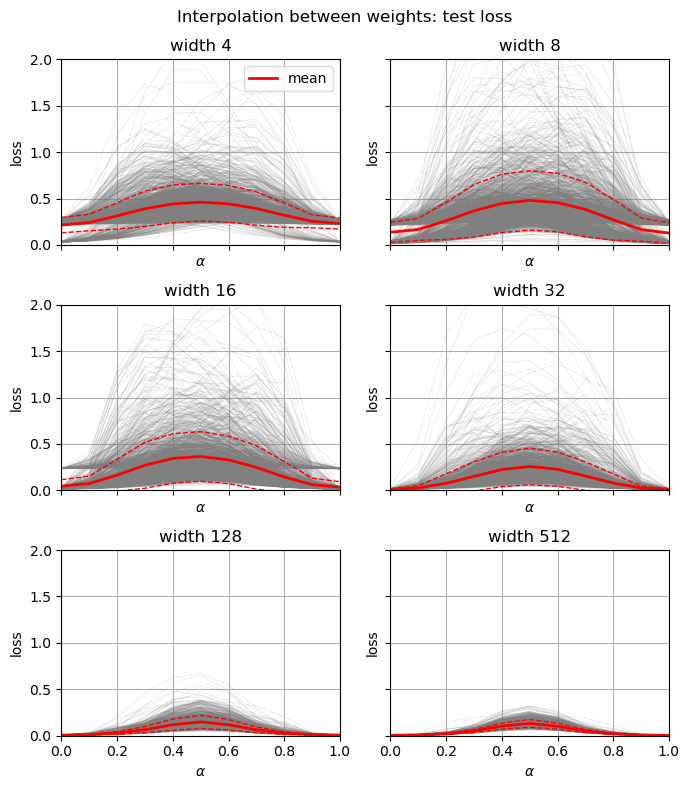

In [ ]:
# visualize naive interpolation losses
for data in ["train", "test"]:
    # create 3*2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(7, 8), sharex=True, sharey=True)

    for i, width in enumerate(widths):
        int_losses = np.load(
            f"logs/moons/naive_int_losses_{data}_w{width}.npy"
        )

        # compute mean values (average across dim 0 and 1)
        int_losses_mean = int_losses.mean(axis=(0, 1))

        # compute standard deviations (average across dim 0 and 1)
        int_losses_std = int_losses.std(axis=(0, 1))

        # plot individual losses as lines in same subplot
        for j in range(int_losses.shape[0]):
            for k in range(int_losses.shape[1]):
                axes[i // 2, i % 2].plot(
                    int_losses[j, k], linewidth=0.5, color="grey", alpha=0.1
                )
        # plot mean as line in same subplot
        axes[i // 2, i % 2].plot(
            int_losses_mean, color="red", linewidth=2, label="mean"
        )
        # show standard deviation as lines around mean
        axes[i // 2, i % 2].plot(
            int_losses_mean + int_losses_std,
            color="red",
            linewidth=1,
            linestyle="--",
        )
        axes[i // 2, i % 2].plot(
            int_losses_mean - int_losses_std,
            color="red",
            linewidth=1,
            linestyle="--",
        )
        # set x axis label
        axes[i // 2, i % 2].set_xlabel("$\\alpha$")
        # set x axis ticks (0 to 1 in steps of 0.2)
        axes[i // 2, i % 2].set_xticks(np.arange(0, 11, 2))
        # set x axis tick labels (0 to 1 in steps of 0.1)
        axes[i // 2, i % 2].set_xticklabels(
            [f"{i / 10:.1f}" for i in range(0, 11, 2)]
        )
        # set x axis limits
        axes[i // 2, i % 2].set_xlim(0, 10)
        # set y axis label
        axes[i // 2, i % 2].set_ylabel("loss")
        # set y axis limits
        axes[i // 2, i % 2].set_ylim(0, 2)
        # set title
        axes[i // 2, i % 2].set_title(f"width {width}")
        # grid
        axes[i // 2, i % 2].grid()

    # set legend
    axes[0, 0].legend(loc="upper right")

    # set suptitle
    fig.suptitle(f"Interpolation between weights: {data} loss")
    # tight layout
    fig.tight_layout()
    # save
    plt.savefig(f"naive_interpolation_losses_{data}.png", dpi=600)

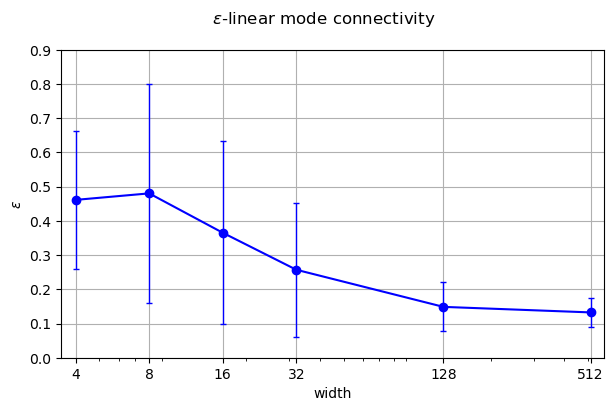

In [ ]:
# visualize naive interpolation losses
epsilon = np.zeros((2,6))
epsilon_std = np.zeros((2,6))
for data in ["test"]:
    for i, width in enumerate(widths):
        int_losses = np.load(
            f"logs/moons/naive_int_losses_{data}_w{width}.npy"
        )
        # compute mean values (average across dim 0 and 1)
        int_losses_mean = int_losses.mean(axis=(0, 1))
        # compute standard deviations (average across dim 0 and 1)
        int_losses_std = int_losses.std(axis=(0, 1))
        # compute epsilon
        if data == "train":
            epsilon[0,i] = int_losses_mean[5]
            epsilon_std[0,i] = int_losses_std[5]
        else:
            epsilon[1,i] = int_losses_mean[5]
            epsilon_std[1,i] = int_losses_std[5]

# visualize
fig, ax = plt.subplots(1,1,figsize=(7,4))
# x axis in log scale
ax.set_xscale("log")
# plot epsilon
ax.plot(widths, epsilon[1], label="test", color="blue", marker="o")
# plot standard deviation as error bars
ax.errorbar(
    widths,
    epsilon[1],
    yerr=epsilon_std[1],
    color="blue",
    linewidth=1,
    linestyle="none",
    capsize=2,
)
# set x axis label
ax.set_xlabel("width")
# set x axis ticks
ax.set_xticks(widths)
# set x axis tick labels
ax.set_xticklabels(widths)
# set x axis limits
ax.set_xlim(3.5, 580)
# set y axis label
ax.set_ylabel("$\\epsilon$")
# set y axis limits
ax.set_ylim(0, 0.9)
# grid
ax.grid()
# set suptitle
fig.suptitle("$\\epsilon$-linear mode connectivity")
# tight layout
# fig.tight_layout()
# save
plt.savefig(f"naive_epsilon.png", dpi=600)

Wait, this is weird. Why is naive interpolation resulting in low loss barrier? Shouldn't naive average of two models be bad? Lets visualize

<div>
<img src="plots/moons/moons_w4.png" width="500"/>
</div>

<div>
<img src="plots/moons/moons_w4_average.png" width="250"/>
</div>

As expected, for small models, the average is very poor. What about large models?

<div>
<img src="plots/moons/moons_w512.png" width="500"/>
</div>

<div>
<img src="plots/moons/moons_w512_average.png" width="250"/>
</div>

It is worse, but not by a lot. Why is that so? Answer might be in the weights

<div>
<img src="plots/moons/moons_w512_weights.png" width="250"/>
</div>

Many low norm weights, lets see their contribution

<div>
<img src="plots/moons/moons_w512_contrib.png" width="250"/>
</div>

If assigned to each other, they dont affect the output. And the odds of this happening increases with width

<div>
<img src="plots/moons/low_norm_fraction.png" width="250"/>
</div>

After removing these low norm hidden nodes, let us look for feature redundancy, i.e., nodes that compute the same function

model 33
<div>
<img src="plots/moons/moons_w512_sim_0.png" width="250"/>
<img src="plots/moons/moons_w512_betti_0.png" width="250"/>
</div>

model 39

<div>
<img src="plots/moons/moons_w512_sim_1.png" width="250"/>
<img src="plots/moons/moons_w512_betti_1.png" width="250"/>
</div>

So this is a result of dead/redundant nodes. Lets see if we can remove them for wide models (w=512)

model comparison

<div>
<img src="plots/moons/model_comparison.png" width="250"/>
</div>

This is upon removing nodes with sim > 0.99, and with both incoming and outgoing weights < 0.1

<div>
<img src="plots/moons/num_nodes.png" width="250"/>
</div>

As you see the number of hidden nodes is much less. Lets see if this helps with interpolation

<div>
<img src="plots/moons/naive_interpolation_losses_red_w512.png" width="250"/>
</div>

We observe that the loss barrier is much higher now. So the decreasing loss barrier is a result of dead/redundant nodes. What about interpolation of models upto permutation?

Lets interpolate between "aligned" models. Note that they were aligned using simple weight matching, and are not reduced in size

<div>
<img src="plots/moons/perm_interpolation_losses_train.png" width="250"/>
</div>

<div>
<img src="plots/moons/perm_interpolation_losses_test.png" width="250"/>
</div>

<div>
<img src="plots/moons/zoomed_perm_interpolation_losses_test.png" width="250"/>
</div>

Surprisingly much lower! Lets see epsilon connectivity

<div>
<img src="plots/moons/perm_epsilon.png" width="250"/>
</div>

Are SWA samples naive or aligned? We take a model of each width and run another 20 epochs to get samples

<div>
<img src="plots/moons/swa_losses.png" width="250"/>
</div>

SWA lowers loss a little for large widths. How do interpolation between samples look like?

<div>
<img src="plots/moons/swa_interpolation_losses_train.png" width="250"/>
</div>

<div>
<img src="plots/moons/swa_interpolation_losses_test.png" width="250"/>
</div>

They are in the same bin. In fact epsilon is exactly zero.

<div>
<img src="plots/moons/swa_epsilon.png" width="250"/>
</div>

In narrow models, what are connected by low barrier? And is everything connected by low barrier in wide models? Lets see the epsilon matrix with hierarchical clustering

To start no clusters are revealed with naive interpolation as expected

<div>
<img src="plots/moons/naive_sim_w4.png" width="250"/>
</div>

<div>
<img src="plots/moons/naive_sim_w512.png" width="250"/>
</div>

But permuted models are do reveal clusters atleast in narrow setting

<div>
<img src="plots/moons/perm_sim_w4.png" width="250"/>
</div>

Take a close look at wide models

<div>
<img src="plots/moons/zoomed_perm_sim_w512.png" width="250"/>
</div>

Why are there no apparent clusters? 

### TODO

How to explain cluster in narrow models? How to explain lack of cluster in wide models? How to measure feature similarity?

Weight alignment method may not be optimal... but Sinkhorn is no better, lets stay with wm


Lets do the same for deeper models trained on MNIST

<div>
<img src="plots/mnist/model_performance.png" width="250"/>
</div>

Naive interpolation

<div>
<img src="plots/mnist/naive_interpolation_losses_test.png" width="250"/>
</div>

<div>
<img src="plots/mnist/naive_epsilon.png" width="250"/>
</div>

Aligned interpolation

<div>
<img src="plots/mnist/perm_interpolation_losses_test.png" width="250"/>
</div>

<div>
<img src="plots/mnist/perm_epsilon.png" width="250"/>
</div>

Clustered epsilon

<div>
<img src="plots/mnist/perm_sim_w8.png" width="250"/>
</div>

<div>
<img src="plots/mnist/perm_sim_w32.png" width="250"/>
</div>

Zoomed in

<div>
<img src="plots/mnist/zoomed_perm_sim_w128.png" width="250"/>
</div>

<div>
<img src="plots/mnist/zoomed_perm_sim_w512.png" width="250"/>
</div>

Why does aligning to zero leaves others unclustered?